In [39]:
import numpy as np
rng = np.random.default_rng(42)
type(rng)

numpy.random._generator.Generator

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from trainAttn_fakedata import SelfAttentionLightning
from data_generation import prepare_data

# # Load your trained model - replace with your actual model path
# model_path = "/media/dan/Data/git/ubiquitous-spork/prediction/src/models/quantized_attention_model_20250401_114748/final_model.ckpt"
# model = SelfAttentionLightning.load_from_checkpoint(model_path)
# model.eval()

# Load the data
train_dataset, val_dataset, n_features = prepare_data(quantize=True, quantization_decimals=2)

# Get features and labels
train_features = train_dataset.tensors[0]
train_labels = train_dataset.tensors[1]

(100000, 3)


In [41]:
train_dataset.tensors[0].mean(axis=0)

tensor([-1.8477e-09,  4.7684e-10])

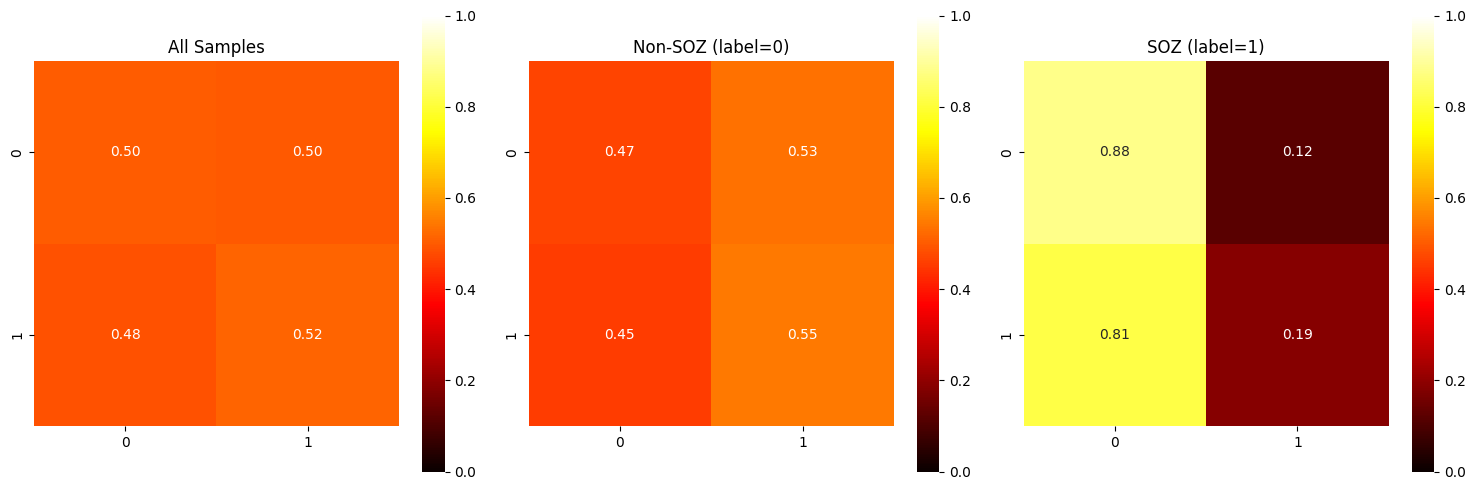

In [4]:
# Get attention scores for all training samples
with torch.no_grad():
    _, attention_weights = model(train_features)

# Convert attention weights to numpy for easier manipulation
attention_weights = attention_weights.numpy()

# Calculate mean attention patterns
mean_all = attention_weights.mean(axis=0).squeeze()
mean_0 = attention_weights[train_labels.squeeze() == 0].mean(axis=0).squeeze()
mean_1 = attention_weights[train_labels.squeeze() == 1].mean(axis=0).squeeze()

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot heatmaps
sns.heatmap(mean_all, annot=True, cbar=True, square=True, fmt='.2f', ax=axes[0], cmap='hot', vmin=0, vmax=1)
sns.heatmap(mean_0, annot=True, cbar=True, square=True, fmt='.2f', ax=axes[1], cmap='hot', vmin=0, vmax=1)
sns.heatmap(mean_1, annot=True, cbar=True, square=True, fmt='.2f', ax=axes[2], cmap='hot', vmin=0, vmax=1)

# Set titles
axes[0].set_title('All Samples')
axes[1].set_title('Non-SOZ (label=0)')
axes[2].set_title('SOZ (label=1)')

plt.tight_layout()
plt.show()

In [5]:
attention_weights[1,...]

array([[0.82707685, 0.17292316],
       [0.7737412 , 0.2262588 ]], dtype=float32)

In [6]:
# Get attention scores for all training samples
with torch.no_grad():
    x, keys, queries, values, attn_output, attn_weights, ln_input, ln_output, fc1_output, fc2_output, out = model.forward_outputs(train_features)

In [32]:
attn_output.shape

torch.Size([64000, 2, 3])

In [29]:
w = model.proj_values.weight.data.numpy()
b = model.proj_values.bias.data.numpy()

x[0,...] @ w.T + b

/tmp/ipykernel_28438/2484863988.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[0,...] @ w.T + b


tensor([[-0.2307, -0.7581, -0.1232],
        [ 0.9674, -1.6849, -0.8541]])

In [8]:
from scipy.io import savemat

# Extract model weights and biases
model_params = {
    # Projection layers
    'proj_keys_weight': model.proj_keys.weight.data.numpy(),
    'proj_keys_bias': model.proj_keys.bias.data.numpy(),
    'proj_queries_weight': model.proj_queries.weight.data.numpy(),
    'proj_queries_bias': model.proj_queries.bias.data.numpy(),
    'proj_values_weight': model.proj_values.weight.data.numpy(),
    'proj_values_bias': model.proj_values.bias.data.numpy(),
    
    # Layer norm parameters
    'ln_weight': model.ln.weight.data.numpy(),
    'ln_bias': model.ln.bias.data.numpy(),
    
    # Fully connected layers
    'fc1_weight': model.fc1.weight.data.numpy(),
    'fc1_bias': model.fc1.bias.data.numpy(),
    'fc2_weight': model.fc2.weight.data.numpy(),
    'fc2_bias': model.fc2.bias.data.numpy(),
    
    # Training data
    'train_features': train_features.numpy(),
    'train_labels': train_labels.numpy(),
    
    # Attention weights from visualization
    'attention_weights': attention_weights,
    'mean_attention_all': mean_all,
    'mean_attention_0': mean_0,
    'mean_attention_1': mean_1
}

# Save to .mat file
save_path = 'models/attention_model_weights_and_data.mat'
savemat(save_path, model_params)
print(f"Model weights, biases, and data saved to: {save_path}")

Model weights, biases, and data saved to: models/attention_model_weights_and_data.mat
